# Magnetic and Diagenetic Analyses of Reilly (2020)
_____

Paper doi: https://doi.org/10.1029/2020GC009380

Core: NBP1203 JKC36 (63.089°S, 55.395°W)

Water depth: 806 m

Data in analysis: Magnetite ppm (from Ms measurements), sedimentation rate, total organic carbon, pore water chemistry.


In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import data_fns
plt.rcParams["font.family"] = "Avenir"
%matplotlib inline

In [2]:
# read in data
magn = pd.read_excel("data/reilly2020.xlsx", sheet_name="Ms")
geochem = pd.read_excel("data/reilly2020.xlsx", sheet_name="IW")
toc = pd.read_excel("data/reilly2020.xlsx", sheet_name="TOC (top half)")
ages = pd.read_excel("data/reilly2020.xlsx", sheet_name="ages")

# unit adjustments: depth to meters, Ms to magnetite, years to Ma
magn["Depth [mbsf]"] = magn["core_depth"] / 100
magn["Magnetite [ppm]"] = (magn["hyst_ms_mass"] * 10**6) / 92
geochem["Depth [mbsf]"] = geochem["Depth"] / 100
toc["Depth [mbsf]"] = toc["Depth (cm)"] / 100
ages["Depth [mbsf]"] = ages["Depth (cmcd)"] / 100
ages["Calibrated age (Ma)"] = ages["Calibrated age (yr BP)"] / 1000000

In [3]:
# calculate sed rates
sed_rates = data_fns.sed_rates(ages["Calibrated age (Ma)"], ages["Depth [mbsf]"])

In [4]:
# combine stuff together
magn_df = pd.DataFrame({"Depth [mbsf]":magn["Depth [mbsf]"], "Magnetite [ppm]":magn["Magnetite [ppm]"]})
geochem_df = pd.DataFrame({"Depth [mbsf]":geochem["Depth [mbsf]"], "Sulfate [mM]":geochem["Sulfate (mM)"], "Sulfide [mM]":geochem["S2- (mM)"], "Fe 2+ [uM]":geochem["Fe2+ (uM)"]})
toc_df = pd.DataFrame({"Depth [mbsf]":toc["Depth [mbsf]"], "TOC [wt. %]":toc["TOC CalcWt%"]})
seds_df = pd.DataFrame({"Depth [mbsf]":ages["Depth [mbsf]"], "Sedimentation Rate [m/Myr]":sed_rates})

comb_df = pd.concat([magn_df, geochem_df, toc_df, seds_df]).sort_values(by="Depth [mbsf]").reset_index(drop=True)

In [5]:
# interpolate
# the sed rate data goes deep enough
# the sulfate comes up 20 cm short (probably close enough)
# the TOC comes up about 2 m short--hmm...
interpolated = data_fns.interpolate(comb_df, ["Sulfate [mM]", "TOC [wt. %]", "Sulfide [mM]", "Fe 2+ [uM]"])

# let's pick an arbitrary cut-off and say that we can't extrapolate TOC below 3.4 m (so taking an extra 15 cm)
# that corresponds to rows 293 onwards
interpolated.loc[293:, "TOC [wt. %]"] = np.nan

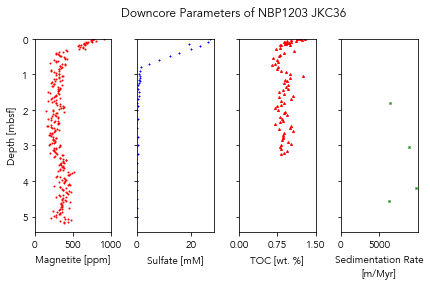

In [6]:
# downcore plots
# looks a little ugly with all parameters, but nicer with just the standard ones
colors = ["r", "b", "r", "g", "y", "k"]
markers = [".", "+", "^", "x", ">", "<"]
comp_markers = [".", ".", ".", "."]
dc_fig, dc_axs = data_fns.plot_dc(["Magnetite [ppm]","Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Myr]"], comb_df, colors, markers)
dc_fig.suptitle("Downcore Parameters of NBP1203 JKC36", x=0.55)
dc_axs[3].set_xlabel("Sedimentation Rate\n[m/Myr]")
#dc_axs[3].set_xticks([5000, 7500, 10000])
dc_axs[0].set_xticks([0, 500, 1000])
dc_axs[2].set_xlim(0, 1.5)
dc_axs[2].set_xticks([0, 0.75, 1.5])
#dc_axs[0].set_ylim(0.8,0)
dc_fig.tight_layout()
dc_fig.savefig("outputs/reilly2020/dc1-aug23.pdf")

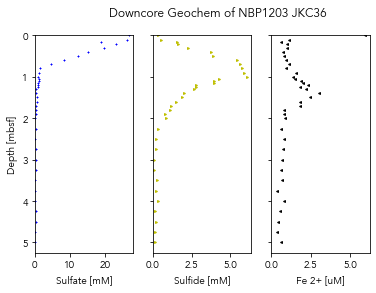

In [15]:
# just plot geochem
geochem_fig, geochem_axes = data_fns.plot_dc(["Sulfate [mM]", "Sulfide [mM]", "Fe 2+ [uM]"], comb_df, ["b", "y", "k"], ["+", ">", "<"])
geochem_fig.suptitle("Downcore Geochem of NBP1203 JKC36", x=0.55)
geochem_fig.savefig("outputs/reilly2020/dc-geochem.pdf", bbox_inches="tight")

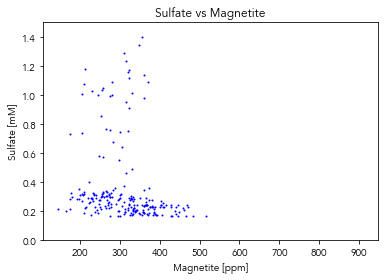

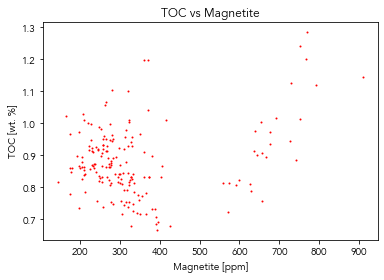

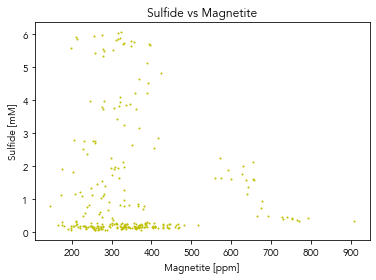

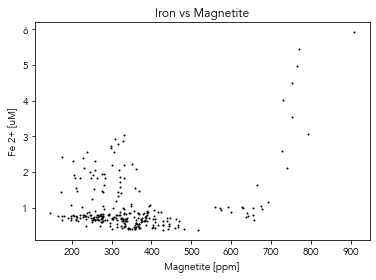

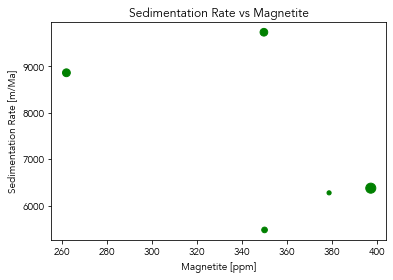

In [13]:
# comparison plots (exclude 0th color so things show up in standard colors)
comp_figs, comp_axs = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]", "Sulfide [mM]", "Fe 2+ [uM]"], interpolated, ["b", "r", "y", "k"], comp_markers)
comp_axs[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite")
comp_axs[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite")
comp_axs[2].set(xlabel="Magnetite [ppm]", ylabel="Sulfide [mM]", title="Sulfide vs Magnetite")
comp_axs[3].set(xlabel="Magnetite [ppm]", ylabel="Fe 2+ [uM]", title="Iron vs Magnetite")
comp_figs[0].savefig("outputs/reilly2020/sulfa-comp.pdf")
comp_axs[0].set_ylim(0, 1.5)
comp_figs[0].savefig("outputs/reilly2020/sulfa-comp-zoom.pdf")
comp_figs[1].savefig("outputs/reilly2020/toc-comp.pdf")
comp_figs[2].savefig("outputs/reilly2020/sulfi-comp.pdf")
comp_figs[3].savefig("outputs/reilly2020/iron-comp.pdf")


# plot the sed rate comp plot separately, since it has a different presentation
sed_fig, sed_ax, sed_sc = data_fns.sed_avg_plot(interpolated)
sed_ax.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Myr]", title = "Sedimentation Rate vs Magnetite")
sed_fig.savefig("outputs/reilly2020/sed-comp.pdf")

In [14]:
# write data to compilations
data_fns.write_output(comb_df, "NBP1203 JKC36", "data/comp_raw.xlsx")
data_fns.write_output(interpolated, "NBP1203 JKC36", "data/comp_inter.xlsx")
